In [1]:
%matplotlib inline
import torch
import torchvision
import math
import seaborn as sns
import pandas as pd

In [2]:
import sys
sys.path.append('..')

In [3]:
from train import cifar_stats

In [130]:
path = '../output/ablation-mnist-models/attempt0/relog-elliptical-maxout_4-max_fit_l1.pkl'

In [131]:
model = torch.load(path, map_location=torch.device('cpu'))

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.ReLog' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.Elliptical' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [132]:
params = [(layer.multiplier, getattr(layer, 'gamma', 1), layer._quadratic.weight, layer.weight, layer.bias) 
           for layer in model.features if hasattr(layer, '_quadratic')]

In [133]:
alpha, gamma, qw, w, b = params[0]

# Examining weight and bias magnitudes

In [134]:
def print_weight_magnitudes(layer_params):
    alpha, gamma, qw, w, b = layer_params
    qw_magnitude = qw.abs().flatten().detach()
    w_magnitude = w.abs().flatten().detach()
    # weights = pd.concat([
    #     pd.DataFrame({'weight': qw_magnitude}).assign(name='quadratic'),
    #     pd.DataFrame({'weight': w_magnitude}).assign(name='linear')
    # ])    
    # _ = sns.boxplot(x='weight', y='name', data=weights)
    qw_desc = pd.Series(qw_magnitude).describe()
    w_desc = pd.Series(w_magnitude).describe()
    print('Quadratic weights:')
    print(qw_desc)
    print('Linear weights:')
    print(w_desc)
    print('Compare:')
    print(qw_desc / w_desc)
    

In [135]:
def compare_weight_magnitudes(layer_params):
    alpha, gamma, qw, w, b = layer_params
    qw_magnitude = qw.abs().flatten().detach()
    w_magnitude = w.abs().flatten().detach()
    qw_desc = pd.Series(qw_magnitude).describe()
    w_desc = pd.Series(w_magnitude).describe()
    print('Compare:', qw_desc.loc['50%'] / w_desc.loc['50%'])
    
# compare_weight_magnitudes(params[0])

In [136]:
print_weight_magnitudes(params[0])

Quadratic weights:
count    1.600000e+03
mean     3.638437e-02
std      1.167463e-01
min      3.904655e-09
25%      5.909559e-06
50%      2.812188e-05
75%      7.454471e-03
max      8.440016e-01
dtype: float64
Linear weights:
count    1.600000e+03
mean     7.110953e-02
std      1.702752e-01
min      1.048441e-09
25%      3.950088e-06
50%      1.608803e-05
75%      3.508710e-02
max      1.809317e+00
dtype: float64
Compare:
count    1.000000
mean     0.511667
std      0.685633
min      3.724249
25%      1.496058
50%      1.748001
75%      0.212456
max      0.466475
dtype: float64


In [137]:
print_weight_magnitudes(params[1])

Quadratic weights:
count    5.120000e+04
mean     2.125250e-02
std      6.041596e-02
min      1.958425e-13
25%      7.232898e-06
50%      3.822045e-05
75%      4.230098e-03
max      8.190984e-01
dtype: float64
Linear weights:
count    5.120000e+04
mean     2.344496e-02
std      5.351230e-02
min      5.834453e-12
25%      8.128078e-07
50%      3.552411e-06
75%      1.013011e-02
max      5.924625e-01
dtype: float64
Compare:
count     1.000000
mean      0.906485
std       1.129011
min       0.033567
25%       8.898657
50%      10.759017
75%       0.417577
max       1.382532
dtype: float64


# Calculating radii

Recall that the net input is calculated as:

$z = \alpha_t \sum_{i=1}^m w^\prime_i x_i^2 + \alpha_t \gamma + \sum_{i=1}^m w_i x_i + b,$

where $\{w^\prime_i\}$ (called quadratic weights here) are constrained to be negative, $\alpha_t=1$ when training is finished, and $\gamma = \sqrt{\text{fan-in}}$.

We rewrite the formula into:

$z = \sum_{i=1}^m w^\prime_i \left(x_i + \frac{w_i}{2w^\prime_i} \right)^2 \underbrace{- \frac{1}{4} \left( \frac{w_i}{w^\prime_i} \right)^2 + \gamma + b}_{b_0},$

and therefore, the boundary is defined as:

$\sum_{i=1}^m w^\prime_i \left(x_i - x^*_i\right)^2 + b_0 = 0$

$\sum_{i=1}^m \frac{\left(x_i - x^*_i\right)^2}{\left(\frac{b_0}{-w^\prime_i}\right)} - 1 = 0$ (notice that $w^\prime_i$ is required to be negative)

So, the radii are $\sqrt{ \frac{b_0}{-w^\prime_i}}$

In [138]:
def plot_radii(layer_params):
    alpha, gamma, qw, w, b = layer_params
    w = w.reshape(w.shape[0],-1)
    qw = alpha*qw.reshape(w.shape[0],-1)
    b0 = -0.25*torch.sum((w/qw)**2, axis=1) + alpha*gamma + b
    radii = torch.sqrt(b0.reshape(b0.shape[0],1)/qw).flatten().detach()    
    _ = sns.boxplot(radii)   
    radii_series = pd.Series(radii)
    print(radii_series.describe())
    return radii

count    7.850000e+02
mean     1.945014e+07
std      1.163678e+08
min      6.029347e+01
25%      1.199092e+03
50%      4.212213e+03
75%      1.797841e+04
max      1.664311e+09
dtype: float64


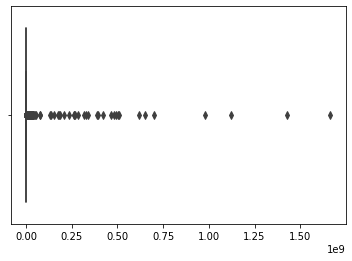

In [139]:
radii = plot_radii(params[0])

count    2.559800e+04
mean     7.962219e+07
std      8.708419e+09
min      1.337063e+02
25%      4.681623e+03
50%      2.532336e+04
75%      2.365792e+05
max      1.392803e+12
dtype: float64


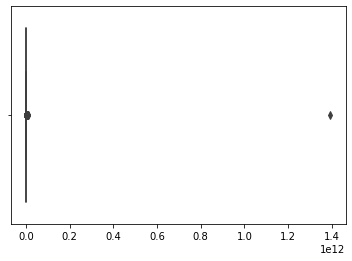

In [140]:
radii = plot_radii(params[1])

# CIFAR-10 models

In [141]:
cifar10_path = '../output/ablation-cifar10-models4/relog-maxout-elliptical-maxfit.pkl'

In [142]:
cifar_model = torch.load(cifar10_path, map_location=torch.device('cpu'))

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.Elliptical' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [143]:
cifar_params = [(layer.multiplier, getattr(layer, 'gamma', 1), layer._quadratic.weight, layer.weight, layer.bias) 
           for layer in cifar_model.features if hasattr(layer, '_quadratic')]

In [144]:
print_weight_magnitudes(cifar_params[0])

Quadratic weights:
count    6.912000e+03
mean     5.708601e-02
std      5.477707e-02
min      2.113152e-10
25%      1.018130e-02
50%      3.723509e-02
75%      9.629107e-02
max      2.826799e-01
dtype: float64
Linear weights:
count    6.912000e+03
mean     1.523758e-01
std      1.460869e-01
min      1.998897e-10
25%      4.731211e-02
50%      1.113780e-01
75%      2.087807e-01
max      1.161551e+00
dtype: float64
Compare:
count    1.000000
mean     0.374640
std      0.374962
min      1.057159
25%      0.215194
50%      0.334313
75%      0.461207
max      0.243364
dtype: float64


count    3.444000e+03
mean     6.787447e+09
std      2.322477e+11
min      1.561221e+01
25%      8.359854e+02
50%      5.333910e+03
75%      2.114975e+06
max      1.311314e+13
dtype: float64


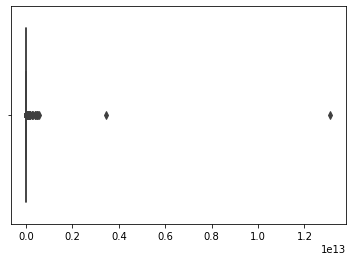

In [145]:
radii = plot_radii(cifar_params[0])

In [146]:
print_weight_magnitudes(cifar_params[1])

Quadratic weights:
count    2.949120e+05
mean     2.149176e-02
std      1.656555e-02
min      6.840399e-12
25%      8.630282e-03
50%      1.946887e-02
75%      3.150595e-02
max      5.682368e-01
dtype: float64
Linear weights:
count    2.949120e+05
mean     3.425395e-02
std      3.249068e-02
min      2.438978e-13
25%      1.270423e-02
50%      2.634260e-02
75%      4.388649e-02
max      5.926669e-01
dtype: float64
Compare:
count     1.000000
mean      0.627424
std       0.509855
min      28.046174
25%       0.679323
50%       0.739064
75%       0.717896
max       0.958779
dtype: float64


count    1.473790e+05
mean     1.093774e+10
std      2.011345e+12
min      1.615974e+02
25%      4.039904e+03
50%      1.790747e+04
75%      3.769648e+05
max      7.621037e+14
dtype: float64


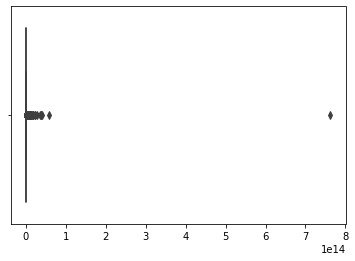

In [147]:
_ = plot_radii(cifar_params[1])

count    5.896190e+05
mean     9.028161e+11
std      4.233583e+14
min      1.734959e+02
25%      1.110484e+04
50%      1.417752e+05
75%      7.084436e+08
max      3.091605e+17
dtype: float64


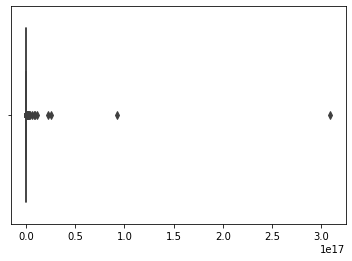

In [148]:
_ = plot_radii(cifar_params[2])

count    1.473790e+05
mean     1.093774e+10
std      2.011345e+12
min      1.615974e+02
25%      4.039904e+03
50%      1.790747e+04
75%      3.769648e+05
max      7.621037e+14
dtype: float64


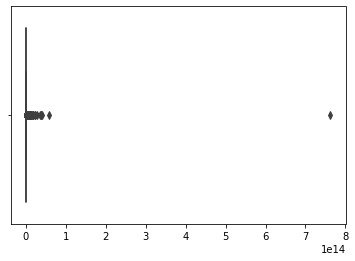

In [149]:
_ = plot_radii(cifar_params[1])

count    1.473790e+05
mean     1.093774e+10
std      2.011345e+12
min      1.615974e+02
25%      4.039904e+03
50%      1.790747e+04
75%      3.769648e+05
max      7.621037e+14
dtype: float64


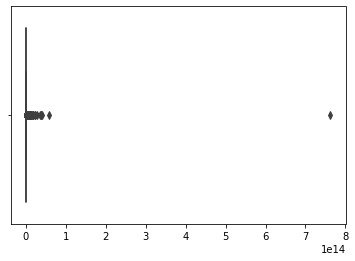

In [150]:
_ = plot_radii(cifar_params[1])

In [151]:
for layer_params in cifar_params:
    compare_weight_magnitudes(layer_params)

Compare: 0.3343127586017516
Compare: 0.7390638304792744
Compare: 0.8882108491288214
Compare: 0.8377484147745108
Compare: 1.013214337202249
Compare: 1.0250799263141157
Compare: 0.9792051063838133
Compare: 1.0193080623849435
